In [1]:
pip install lightning

In [2]:
pip install segmentation_models_pytorch


In [3]:
import segmentation_models_pytorch as smp

from pprint import pprint
from torch.utils.data import DataLoader

import torch
from torch import nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import lightning as L

import albumentations as A

# Dataset

In [4]:
import os
import torch
import shutil
import numpy as np

from PIL import Image
from tqdm import tqdm
from urllib.request import urlretrieve


class OxfordPetDataset(torch.utils.data.Dataset):
    def __init__(self, root, mode="train", transforms=None):

        assert mode in {"train", "valid", "test"}

        self.root = root
        self.mode = mode
        self.transforms = transforms

        self.images_directory = os.path.join(self.root, "images")
        self.masks_directory = os.path.join(self.root, "annotations", "trimaps")

        self.filenames = self._read_split()  # read train/valid/test splits

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):

        filename = self.filenames[idx]
        image_path = os.path.join(self.images_directory, filename + ".jpg")
        mask_path = os.path.join(self.masks_directory, filename + ".png")

        image = np.array(Image.open(image_path).convert("RGB"))

        trimap = np.array(Image.open(mask_path))
        mask = self._preprocess_mask(trimap)

        sample = dict(image=image, mask=mask, trimap=trimap)

        if self.transforms is not None:
            sample = self.transforms(image=sample["image"], mask=sample["mask"])

        return sample

    @staticmethod
    def _preprocess_mask(mask):
        mask = mask.astype(np.float32)
        mask[mask == 2.0] = 0.0
        mask[(mask == 1.0) | (mask == 3.0)] = 1.0
        return mask

    def _read_split(self):
        split_filename = "test.txt" if self.mode == "test" else "trainval.txt"
        split_filepath = os.path.join(self.root, "annotations", split_filename)
        with open(split_filepath) as f:
            split_data = f.read().strip("\n").split("\n")
        filenames = [x.split(" ")[0] for x in split_data]
        if self.mode == "train":  # 90% for train
            filenames = [x for i, x in enumerate(filenames) if i % 10 != 0]
        elif self.mode == "valid":  # 10% for validation
            filenames = [x for i, x in enumerate(filenames) if i % 10 == 0]
        return filenames

    @staticmethod
    def download(root):

        # load images
        filepath = os.path.join(root, "images.tar.gz")

        download_url(
            url="https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz",
            filepath=filepath,
        )

        extract_archive(filepath)

        # load annotations
        filepath = os.path.join(root, "annotations.tar.gz")

        download_url(
            url="https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz",
            filepath=filepath,
        )

        extract_archive(filepath)


class SimpleOxfordPetDataset(OxfordPetDataset):
    def __getitem__(self, *args, **kwargs):

        sample = super().__getitem__(*args, **kwargs)

        # resize images
        image = np.array(Image.fromarray(sample["image"]).resize((256, 256), Image.BILINEAR))
        mask = np.array(Image.fromarray(sample["mask"]).resize((256, 256), Image.NEAREST))
        #trimap = np.array(Image.fromarray(sample["trimap"]).resize((256, 256), Image.NEAREST))

        # convert to other format HWC -> CHW
        sample["image"] = np.moveaxis(image, -1, 0)
        sample["mask"] = np.expand_dims(mask, 0)
        #sample["trimap"] = np.expand_dims(trimap, 0)

        return sample


class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, filepath):
    directory = os.path.dirname(os.path.abspath(filepath))
    os.makedirs(directory, exist_ok=True)
    if os.path.exists(filepath):
        return

    with TqdmUpTo(
        unit="B",
        unit_scale=True,
        unit_divisor=1024,
        miniters=1,
        desc=os.path.basename(filepath),
    ) as t:
        urlretrieve(url, filename=filepath, reporthook=t.update_to, data=None)
        t.total = t.n


def extract_archive(filepath):
    extract_dir = os.path.dirname(os.path.abspath(filepath))
    dst_dir = os.path.splitext(filepath)[0]
    if not os.path.exists(dst_dir):
        shutil.unpack_archive(filepath, extract_dir)

# Model

In [5]:
class ASPPConv(nn.Sequential):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, padding: int = 0, dilation: int = 1):
        super().__init__(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, dilation=dilation, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
            )


class ASPPPooling(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        self.layers = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return F.interpolate(self.layers(x), x.shape[-1], mode="bilinear", align_corners=False)

class ASPP(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        self.heads = nn.ModuleList([
            ASPPConv(in_channels, out_channels, 1),
            ASPPConv(in_channels, out_channels, 3, 6, 6),
            ASPPConv(in_channels, out_channels, 3, 12, 12),
            ASPPConv(in_channels, out_channels, 3, 18, 18),
            ASPPPooling(in_channels, out_channels)
        ])

        self.out = ASPPConv(out_channels * len(self.heads), out_channels, 1)

    def forward(self, x):
        outputs = []
        for h in self.heads:
            outputs.append(h(x))

        output = torch.cat(outputs, 1)
        return self.out(output)

class DeepLabV3Plus(nn.Sequential):
    def __init__(self, mobilenet: nn.Module, in_channels: int, out_channels: int, num_labels: int):
        super().__init__()

        self.low_level_extractor = mobilenet.features[:4]
        self.low_level_conv = ASPPConv(24, 48, 1)
        self.backbone = mobilenet.features[4:-2]

        self.aspp = nn.Sequential(
            ASPP(in_channels, out_channels),
            nn.Dropout(0.3)
        )

        self.logits = nn.Sequential(
            nn.Conv2d(304, out_channels, 3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, num_labels, 1),
        )

    def forward(self, x):
        output = self.low_level_extractor(x)
        low_level_output = self.low_level_conv(output)

        output = self.backbone(output)
        aspp_output = F.interpolate(self.aspp(output), low_level_output.shape[-1], mode="bilinear", align_corners=False)
        output = torch.cat([low_level_output, aspp_output], 1)
        return F.interpolate(self.logits(output), x.shape[-1], mode="bilinear", align_corners=False)


# DataLoader

In [6]:
transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
        ], p=0.25),
        ], p=1.0)

root = "./data"
SimpleOxfordPetDataset.download(root)

train_dataset = SimpleOxfordPetDataset(root, "train", transforms=transform)
valid_dataset = SimpleOxfordPetDataset(root, "valid")
test_dataset = SimpleOxfordPetDataset(root, "test")

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Train Class

In [7]:
class PetModel(L.LightningModule):
    def __init__(self, backbone: nn.Module, in_channels: int, out_channels: int, num_labels: int):
        super().__init__()
        self.model = DeepLabV3Plus(backbone, in_channels, out_channels, num_labels)

        self.register_buffer("std", torch.tensor([[0.229, 0.224, 0.225]]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))

        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def training_step(self, batch, batch_idx):
        iamge = batch["image"]
        mask = batch["mask"]

        x = iamge / 255
        x = (x - self.mean) / self.std
        pred = self.model(x).sigmoid()

        loss = self.loss_fn(pred, mask)

        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

# Hyper Parameters

In [8]:
in_channels = 160
out_channels = 256

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train

In [9]:
mobilenet = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
model = PetModel(mobilenet, in_channels, out_channels, num_labels=1)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:

trainer = L.Trainer(
    max_epochs=5,
)

trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader,
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type          | Params
------------------------------------------
0 | model   | DeepLabV3Plus | 3.6 M 
1 | loss_fn | DiceLoss      | 0     
----------------------------

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


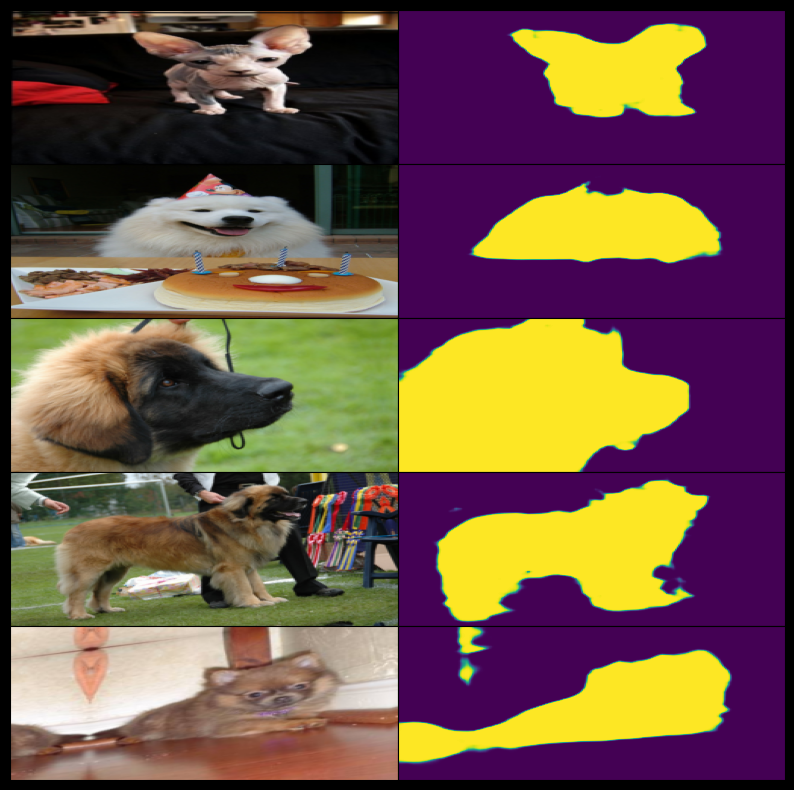

In [11]:
batch = next(iter(train_dataloader))
x = ((batch['image']/255) - torch.tensor([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)) / torch.tensor([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1)
outputs = model.model(x).sigmoid()
figsize = 10

rows = min(outputs.shape[0], 5)

fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(figsize, figsize))
for i in range(rows):

    axes[i][0].imshow(batch['image'][i].permute(1, 2, 0), aspect='auto')
    axes[i][1].imshow(outputs[i][0].detach().numpy(), aspect='auto')

plt.setp(axes, xticks=[], yticks=[])
fig.set_facecolor('black')
plt.subplots_adjust(wspace=0, hspace=0)